In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sn
from sklearn.model_selection import train_test_split

**Note on the data**

The data was already modified to include the 'shifted rate of change' as boolean, which is the rate of change of the following day, where 1 is a positive number and 0 is a negative one.


In [2]:
df_full = pd.read_csv('dataload_2021-05-28.csv', index_col="date", parse_dates=["date"])
df_full.dropna(inplace=True)
df = df_full[:int((len(df_full)*4/5))]
df_eval = df_full[int((len(df_full)*4/5))+1:]
df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,roc,sma,...,SlowD,adx,cci,Aroon Up,Aroon Down,Real Lower Band,Real Middle Band,Real Upper Band,ad,shifted_ROC_BOOL
date,,,,,,,,,,,,,,,,,,,,,
1999-12-28,28.50,28.94,28.38,28.75,14.375,780300.0,0.0,1.0,-0.6565,14.6350,...,35.4404,43.5091,-48.0229,35.0,60.0,13.4313,14.6350,15.8387,6.374274e+07,0
1999-12-29,28.75,28.81,28.00,28.44,14.220,522600.0,0.0,1.0,-1.0783,14.6398,...,29.0019,42.3421,-69.9336,30.0,55.0,13.4434,14.6398,15.8361,6.383307e+07,1
1999-12-30,28.50,28.75,27.81,28.44,14.220,892400.0,0.0,1.0,0.0000,14.6633,...,28.8651,41.1439,-82.6652,25.0,50.0,13.5204,14.6633,15.8061,6.444066e+07,1
1999-12-31,28.44,28.94,28.00,28.94,14.470,882800.0,0.0,1.0,1.7581,14.6243,...,37.3124,40.0687,-52.8434,20.0,45.0,13.5113,14.6243,15.7372,6.620626e+07,1
2000-01-03,29.94,31.19,29.38,31.00,15.500,3921600.0,0.0,1.0,7.1182,14.6243,...,53.5034,39.6958,113.0544,15.0,40.0,13.5113,14.6243,15.7372,7.240282e+07,0


In [3]:
df.sort_index(axis=0, ascending=True, inplace=True)

In [4]:
x = df.drop(['1. open', '2. high', '3. low', '5. adjusted close', '7. dividend amount', '8. split coefficient',
             'shifted_ROC_BOOL'], axis=1).copy()

x.head()

,4. close,6. volume,roc,sma,ema,rsi,obv,MACD_Signal,MACD,MACD_Hist,SlowK,SlowD,adx,cci,Aroon Up,Aroon Down,Real Lower Band,Real Middle Band,Real Upper Band,ad
date,,,,,,,,,,,,,,,,,,,,
1999-12-28,28.75,780300.0,-0.6565,14.6350,14.2512,58.0771,43062400.0,0.7219,0.4981,-0.2239,27.4304,35.4404,43.5091,-48.0229,35.0,60.0,13.4313,14.6350,15.8387,6.374274e+07
1999-12-29,28.44,522600.0,-1.0783,14.6398,14.2483,57.0397,42017200.0,0.6661,0.4426,-0.2235,28.5393,29.0019,42.3421,-69.9336,30.0,55.0,13.4434,14.6398,15.8361,6.383307e+07
1999-12-30,28.44,892400.0,0.0000,14.6633,14.2456,57.0397,42017200.0,0.6117,0.3941,-0.2176,30.6254,28.8651,41.1439,-82.6652,25.0,50.0,13.5204,14.6633,15.8061,6.444066e+07
1999-12-31,28.94,882800.0,1.7581,14.6243,14.2670,58.3687,43782800.0,0.5636,0.3716,-0.1921,52.7724,37.3124,40.0687,-52.8434,20.0,45.0,13.5113,14.6243,15.7372,6.620626e+07
2000-01-03,31.00,3921600.0,7.1182,14.6243,14.3844,63.2931,51626000.0,0.5373,0.4318,-0.1055,77.1122,53.5034,39.6958,113.0544,15.0,40.0,13.5113,14.6243,15.7372,7.240282e+07


## Correlation of features

In [30]:
corrMatrix = x.corr(method='spearman')

,4. close,6. volume,roc,sma,ema,rsi,obv,MACD_Signal,MACD,MACD_Hist,SlowK,SlowD,adx,cci,Aroon Up,Aroon Down,Real Lower Band,Real Middle Band,Real Upper Band,ad
4. close,1.000000,-0.285411,0.020397,0.988611,0.990873,0.158022,0.827591,0.122685,0.112317,0.045308,0.057453,0.061048,0.043950,0.077640,0.079369,-0.072197,0.982834,0.988611,0.984216,0.877749
6. volume,-0.285411,1.000000,0.008331,-0.281970,-0.282028,-0.001433,-0.296397,-0.000138,-0.005878,-0.020384,0.005528,0.008754,0.095970,-0.002069,0.088824,0.085567,-0.274261,-0.281970,-0.282316,-0.467936
roc,0.020397,0.008331,1.000000,-0.027135,-0.025329,0.282371,0.038921,0.044923,0.082479,0.165909,0.279276,0.107655,0.019900,0.328414,0.096118,-0.113527,-0.027401,-0.027135,-0.027300,-0.002726
sma,0.988611,-0.281970,-0.027135,1.000000,0.999470,0.046585,0.817836,0.054119,0.021893,-0.044103,-0.033407,-0.030392,0.029355,-0.039878,-0.002553,0.011040,0.992851,1.000000,0.996102,0.881104
ema,0.990873,-0.282028,-0.025329,0.999470,1.000000,0.056766,0.819447,0.055436,0.029186,-0.022240,-0.022648,-0.016636,0.031158,-0.022792,0.008821,-0.000281,0.992290,0.999470,0.995600,0.882490


<AxesSubplot:>

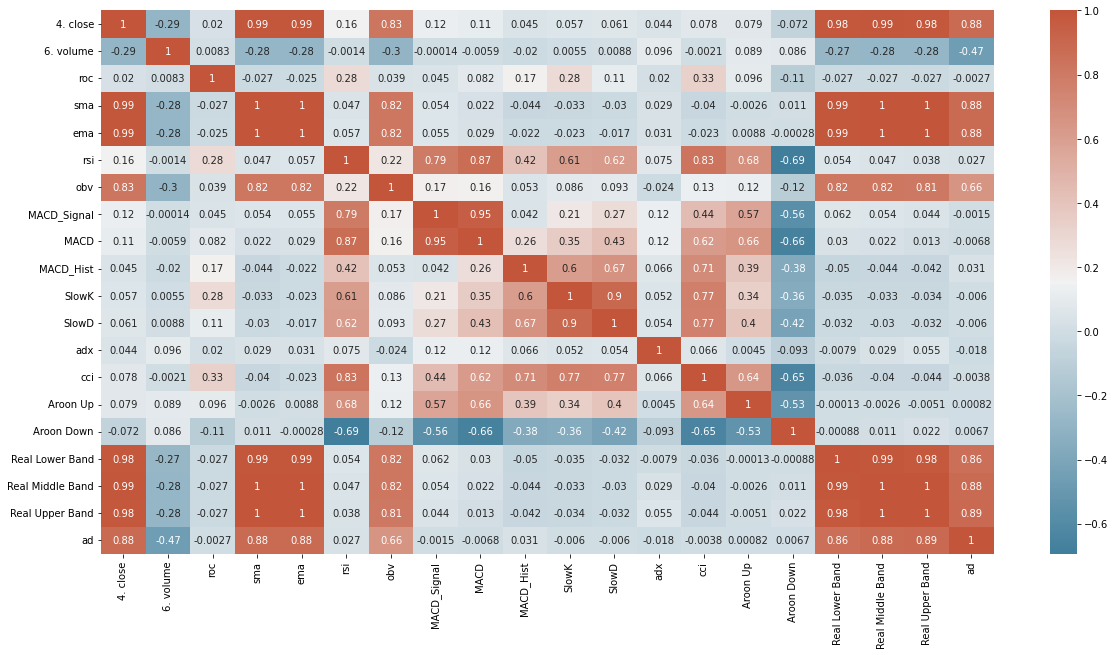

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
cmap = sn.diverging_palette(230, 20, as_cmap=True)
sn.heatmap(corrMatrix, annot=True, ax=ax, cmap=cmap)

## Correlation of features including the shifted boolean ROC

We can see below that the shifted ROC (as boolean) does not have any strong correlation to any of the features.

<AxesSubplot:>

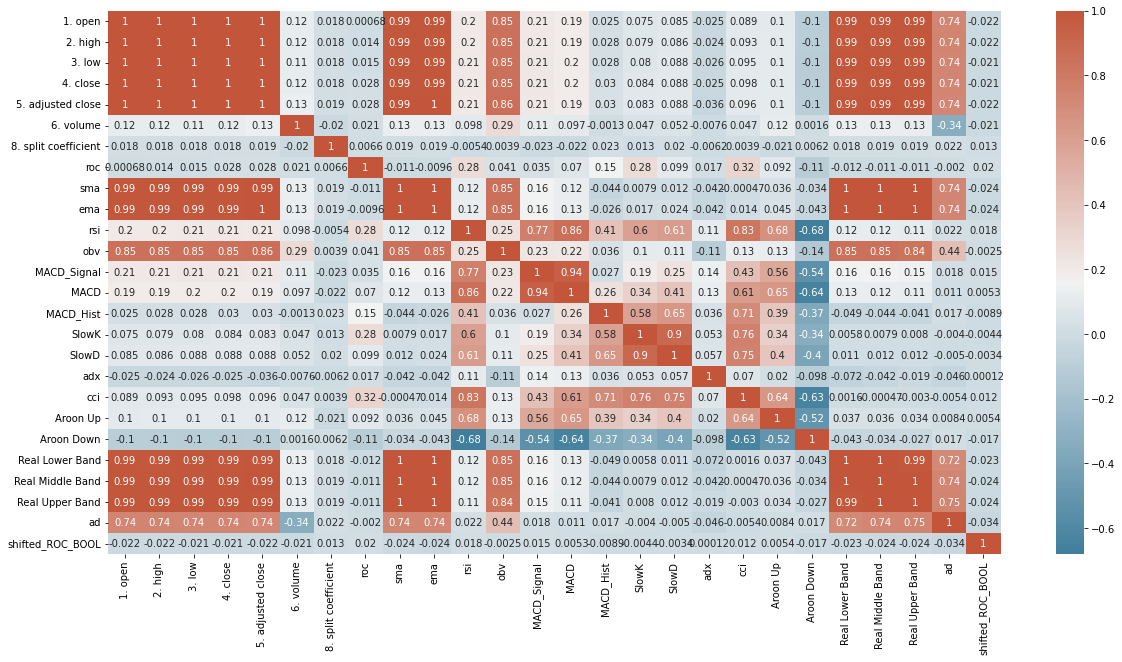

In [41]:
corrMatrix_with_y = df_full.drop(['7. dividend amount'], axis=1).corr(method='spearman')

fig_with_y, ax_with_y = plt.subplots(figsize=(20,10))
sn.heatmap(corrMatrix_with_y, annot=True, ax=ax_with_y, cmap=cmap)

In [6]:
y = df['shifted_ROC_BOOL'].copy()
y.head()

date
1999-12-28    0
1999-12-29    1
1999-12-30    1
1999-12-31    1
2000-01-03    0
Name: shifted_ROC_BOOL, dtype: int64

## Data splits
Splitting the data into train, test and eval set.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=False)

In [8]:
x_eval = df_eval.drop(
    ['1. open', '2. high', '3. low', '5. adjusted close', '7. dividend amount', '8. split coefficient',
     'shifted_ROC_BOOL'], axis=1).copy()
y_eval = df_eval['shifted_ROC_BOOL'].copy()

eval_set = [(xgb.DMatrix(x_eval, label=y_eval), 'eval')]

## Generate Metrics

Prints accuracy, precision, recall and f-score for the in-sample (training) set and for the test set.  
Displays the confusion matrix, as well as the XGboost-determined importance of features.


In [9]:
def generate_metrics(y_train,y_test,predictions, predictions_in_sample):
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

    accuracy_out = accuracy_score(y_test, predictions)
    accuracy_in = accuracy_score(y_train, predictions_in_sample)

    precision_out = precision_score(y_test, predictions)
    precision_in = precision_score(y_train, predictions_in_sample)

    recall_out = recall_score(y_test, predictions)
    recall_in = recall_score(y_train, predictions_in_sample)

    f_score_out = f1_score(y_test, predictions)
    f_score_in = f1_score(y_train, predictions_in_sample)

    print(f"Accuracy out-of-sample: {accuracy_out}")
    print(f"Precision out-of-sample: {precision_out}")
    print(f"Recall out-of-sample: {recall_out}")
    print(f"FScore out-of-sample: {f_score_out}\n")

    print(f"Accuracy in-sample: {accuracy_in}")
    print(f"Precision in-sample: {precision_in}")
    print(f"Recall in-sample: {recall_in}")
    print(f"FScore in-sample: {f_score_in}")
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    cm_out = confusion_matrix(y_test, predictions) / len(y_test) * 100
    cm_in = confusion_matrix(y_train, predictions_in_sample) / len(y_train) * 100

    ax[0].set_title("Confusion Matrix - Out-of-Sample")
    ax[1].set_title("Confusion Matrix - In-Sample")

    ax[0] = ConfusionMatrixDisplay(confusion_matrix=cm_out).plot(ax=ax[0], cmap='Greys')
    ax[1] = ConfusionMatrixDisplay(confusion_matrix=cm_in).plot(ax=ax[1], cmap='Greys')

    plt.show()
    xgb.plot_importance(model)
    plt.show()

## Training
Set the parameters and train the model

In [10]:
train = xgb.DMatrix(x_train, label=y_train)
test = xgb.DMatrix(x_test, label=y_test)
param = {
    'max_depth': 14,
    'eta': 0.2,
    'objective': 'binary:hinge',
    'gamma': 2,
    'subsample': 0.33,
    'eval_metric': 'error' # Binary classification error rate 
}
epochs = 300

model = xgb.train(params=param, dtrain=train, num_boost_round=epochs, evals=eval_set, early_stopping_rounds=20)

[0]	eval-error:0.47075
[1]	eval-error:0.47075
[2]	eval-error:0.47354
[3]	eval-error:0.45682
[4]	eval-error:0.46147
[5]	eval-error:0.46147
[6]	eval-error:0.46982
[7]	eval-error:0.48468
[8]	eval-error:0.47818
[9]	eval-error:0.50046
[10]	eval-error:0.49396
[11]	eval-error:0.49211
[12]	eval-error:0.49304
[13]	eval-error:0.48839
[14]	eval-error:0.49954
[15]	eval-error:0.50325
[16]	eval-error:0.50604
[17]	eval-error:0.50232
[18]	eval-error:0.49954
[19]	eval-error:0.50511
[20]	eval-error:0.50139
[21]	eval-error:0.49675
[22]	eval-error:0.49211
[23]	eval-error:0.49675


## Prediction
Predict the results and generate the metrics

Accuracy out-of-sample: 0.5320959010054138
Precision out-of-sample: 0.5603328710124826
Recall out-of-sample: 0.5838150289017341
FScore out-of-sample: 0.5718329794762915

Accuracy in-sample: 0.9038461538461539
Precision in-sample: 0.8788800973828362
Recall in-sample: 0.9407166123778502
FScore in-sample: 0.908747640025173


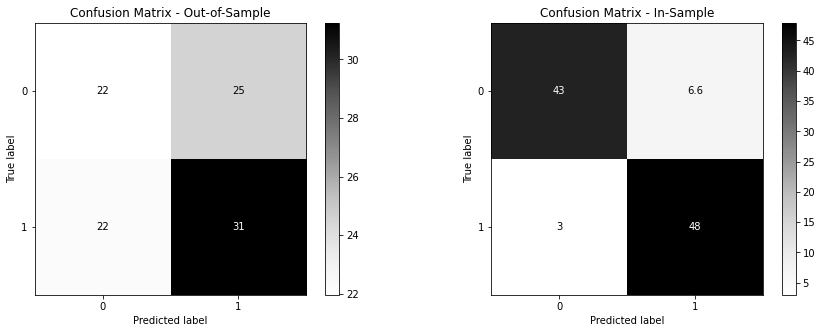

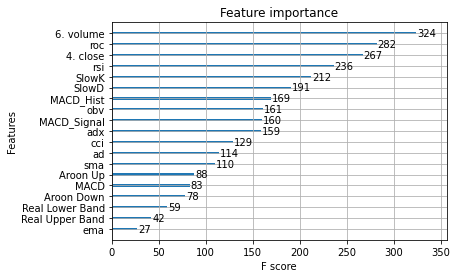

In [11]:
predictions_in_sample = model.predict(train)
predictions = model.predict(test)

generate_metrics(y_train, y_test, predictions, predictions_in_sample)

### "Well" working params: 

param = {
    'max_depth': 11,
    'eta': 0.1,
    'objective': 'binary:hinge',
    'gamma': 2,
    'subsample': 0.33,
    'eval_metric': 'error' # Binary classification error rate 
}
epochs = 300 # Epochs are limited by early stopping